In [2]:
import pandas as pd
import requests
from pandas import json_normalize 
import numpy as np
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import re
import warnings
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
from folium.plugins import MarkerCluster
import os
from pathlib import Path
from leads.data import get_save_data

# Help functions

In [3]:
def get_postcode(fulladdress):
    try:
        postcode=re.search(r'[A-Z][A-Z][0-9]\s[0-9][A-Z][A-Z]', fulladdress).group(0)
    except Exception:
        postcode= 'nomatch' 
        try:
            postcode=re.search(r'[A-Z][A-Z][0-9][0-9]\s[0-9][A-Z][A-Z]', fulladdress).group(0)
        except Exception:
            postcode= 'nomatch' 
            try:
                postcode=re.search(r'[A-Z][0-9]\s[0-9][A-Z][A-Z]', fulladdress).group(0)
            except Exception:
                postcode= 'nomatch'
                try:
                    postcode=re.search(r'[A-Z][0-9][0-9]\s[0-9][A-Z][A-Z]', fulladdress).group(0)
                except Exception:
                    postcode= 'nomatch'
                    try:
                        postcode=re.search(r'[A-Z][0-9][A-Z]\s[0-9][A-Z][A-Z]', fulladdress).group(0)
                    except Exception:
                        postcode= 'nomatch'
                        try:
                            postcode=re.search(r'[A-Z][A-Z][0-9][A-Z]\s[0-9][A-Z][A-Z]', fulladdress).group(0)
                        except Exception:
                            postcode= 'nomatch'
                            try:
                                postcode=re.search(r'\s[A-Z][A-Z][0-9][0-9]', fulladdress).group(0)
                            except Exception:
                                postcode= 'nomatch'
                                try:
                                    postcode=re.search(r'\s[A-Z][A-Z][0-9]', fulladdress).group(0)
                                except Exception:
                                    postcode= 'nomatch'
                                    try:
                                        postcode=re.search(r'\s[A-Z][0-9][0-9]', fulladdress).group(0)
                                    except Exception:
                                        postcode= 'nomatch'
            
    return postcode

In [4]:
def dist(lat1, long1, lat2, long2):
    return np.abs((lat1-lat2)+(long1-long2))

In [5]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [6]:
def match_restaurant(lat, long):
    distances = df.apply(
        lambda row: haversine(lat, long, float(row['Geocode.Latitude']), float(row['Geocode.Longitude'])), 
        axis=1)
    closest=distances.min()
    if closest>0.005:
        return 'nomatch'
    else:
        return df.loc[distances.idxmin(), 'BusinessName'],closest

In [7]:
def return_paretto(df,column_name,column_name_sum,threshold):
    #df is a grouped dataframe
    
    grouped_df=df
    grouped_df=grouped_df.rename(columns={column_name_sum: "count"})
    grouped_df=grouped_df.reset_index().sort_values(by=['count'],ascending=False).reset_index(drop=True)
    
    total=grouped_df['count'].sum()
    grouped_df['percentage']=(grouped_df['count']/total)*100
    
    index_paretto=grouped_df['percentage'].cumsum().searchsorted(threshold)
    paretto_list=grouped_df[column_name][0:index_paretto+1].values.tolist()
    return grouped_df, paretto_list

# Load Uber data 

We will load Uber data provided with columns: <br>

    -Name <br>
    -Cuisine <br>
    -Address <br>
    -Latitude <br>
    -Longitude <br>
    -Average_rating <br>
    -Reviews_count <br>
    -Merchant Category <br>
    -City_name <br>
    
We extract **Post Code** with the function **_get_postcode_** and a LatLon column, which is a concatenation of latitute and longitude

In [29]:
data = pd.read_csv("../london-food-delivery/ubereats.csv")

In [30]:
original_data=data.copy()

In [31]:
data['postcode']=data['address'].apply(get_postcode)

In [32]:
data['latlon']=data.apply(
    lambda row: str(round(row['latitude'],4))+str(round(row['longitude'],4)), 
    axis=1)

# Load UK Food Standard Agency data

We will load data from the UK Food Standard Agency. It has 32 Columns, being the most important ones: <br>

    -Business Name <br>
    -Business Type <br>
    -Address <br>
    -PostCode <br>
    -Latitude <br>
    -Longitude <br>
    -Rating Value (related to hygiene) <br>
    
We add a LatLon column, which is a concatenation of latitute and longitude

In [56]:
city='london'
url = "http://ratings.food.gov.uk/search/^/%s/1/30/json"%city
response = requests.get(url).json()
page_count=int(response['FHRSEstablishment']['Header']['PageCount'])
df=json_normalize(response['FHRSEstablishment']['EstablishmentCollection']['EstablishmentDetail'])
for page in range(1,page_count):
    url = f"http://ratings.food.gov.uk/search/^/{city}/{page}/30/json"
    response = requests.get(url).json()
    df_iter = json_normalize(response['FHRSEstablishment']['EstablishmentCollection']['EstablishmentDetail'])
    df=pd.concat([df, df_iter], axis= 0)

In [33]:
#df.to_csv('/home/louisedantas/code/LouiseDantas/london-food-delivery/UKFoodAgency.csv')

In [34]:
#df=pd.read_csv('../london-food-delivery/UKFoodAgencyLondon.csv')

In [57]:
df=df.reset_index(drop=True)

In [58]:
df=df.rename(columns={"PostCode": "postcode"})
df['Geocode.Longitude']=pd.to_numeric(df['Geocode.Longitude'],downcast='float')
df['Geocode.Latitude']=pd.to_numeric(df['Geocode.Latitude'],downcast='float')
df=df.rename(columns={"Geocode.Latitude": "latitude", "Geocode.Longitude": "longitude"})

In [59]:
df['latlon']=df.apply(
    lambda row: str(round(row['latitude'],4))+str(round(row['longitude'],4)), 
    axis=1)

# Load London Census Data

We found London demographic data with some interesting information such as:
    
    -PostCode <br>
    -Latitude <br>
    -Longitude <br>
    -Average Income <br>
    -Rural/urban <br>
    -others <br>

We hope to merge with the uber dataset and UK Food Agency dataset to hopefully find  correlation among neighboorhood preferences, cuisine, income.

In [38]:
census = pd.read_csv("../london-food-delivery/London postcodes.csv")

/home/louisedantas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
census=census.rename(columns={"Postcode": "postcode"})

In [40]:
census['latlon']=census.apply(
    lambda row: str(round(row['Latitude'],4))+str(round(row['Longitude'],4)), 
    axis=1)

# Merge census data into Uber data and UK Food Agency data

We are adding avegerage income and london zone for every postcode 

In [80]:
data=data.merge(census[['London zone','postcode','ITL level 2','Average Income']],how='left',on=['postcode'])

In [81]:
df=df.merge(census[['London zone','postcode','ITL level 2','Average Income']],how='left',on=['postcode'])

# Find restaurants are not in Uber Eats

Now that we have the two datasets: <br>
    
    1.London Ubereats Restaurants
    2.UK Food Agency data
We will identify London restaurants that are not in Uber Eats Platform.

We did that by matching the latitude and longitude to identify common restaurants. The accuracy used is 11 meters.


## London Restaurants in Uber eats

In [65]:
incommon_df = df.merge(data,on=['latlon'])

<AxesSubplot:xlabel='BusinessType', ylabel='count'>

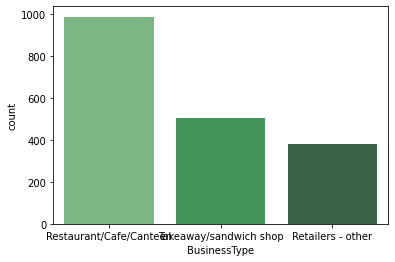

In [68]:
sns.countplot(x="BusinessType", data=incommon_df, palette="Greens_d",
              order=incommon_df.BusinessType.value_counts().iloc[:3].index)

In [69]:
#uber_latlon=data['latlon']
#match_uber=df[df['latlon'].isin(uber_latlon)].copy()
#not_uber=df[~df['latlon'].isin(uber_latlon)].copy()
uber_latlon=incommon_df['latlon']
not_uber=df[~df['latlon'].isin(uber_latlon)].copy()

In [70]:
not_uber

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine2,AddressLine3,AddressLine4,postcode,...,Distance.@xsi:nil,Scores.Hygiene.@xsi:nil,Scores.Structural.@xsi:nil,Scores.ConfidenceInManagement.@xsi:nil,Geocode.Longitude.@xsi:nil,Geocode.Latitude.@xsi:nil,latlon,London zone,ITL level 2,Average Income
0,468824,1317,"""Rio Cinema""",Restaurant/Cafe/Canteen,1,Rio Cinema Dalston,103-107 Kingsland High Street,London,None,E8 2PB,...,true,NaN,NaN,NaN,NaN,NaN,51.5495-0.0756,2.0,Inner London - East,56000.0
1,1177669,19/00376/COMM,% Arabica,Takeaway/sandwich shop,7844,Basement And Ground Floor,5 King Street,Covent Garden,London,WC2E 8HN,...,true,NaN,NaN,NaN,NaN,NaN,51.5117-0.124,1.0,Inner London - West,59000.0
2,1220366,191074,% Arabica,Manufacturers/packers,7839,Railway Arch 214,Ponsford Street,Hackney,London,E9 6JU,...,true,NaN,NaN,NaN,NaN,NaN,51.5473-0.0485,2.0,Inner London - East,52200.0
3,1225476,130435,%Arabica,Other catering premises,7841,Basement To Ground Floor,33 Broadway Market,Hackney,London,E8 4PH,...,true,NaN,NaN,NaN,NaN,NaN,51.5365-0.0621,2.0,Inner London - East,56900.0
4,463541,PI/000187321,( Pitches 46 & 47 & 48)Jean Hogg,Retailers - other,4613,Lewisham Market,Lewisham High Street,Hither Green,London,SE13 6JG,...,true,NaN,NaN,NaN,NaN,NaN,51.462-0.0108,2.0,Inner London - East,50700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43824,495898,12/00225/COMM,Zula Cafe,Restaurant/Cafe/Canteen,1,Shop,189 Ferndale Road,London,None,SW9 8BA,...,true,NaN,NaN,NaN,NaN,NaN,51.4639-0.1164,2.0,Inner London - East,67300.0
43825,428126,01521/0005/0/000,Zuma,Restaurant/Cafe/Canteen,1,5 Raphael Street,London,None,None,SW7 1DL,...,true,NaN,NaN,NaN,NaN,NaN,51.5009-0.1629,1.0,Inner London - West,56300.0
43826,1246213,20/00197/COMM,Zumak39,Restaurant/Cafe/Canteen,1,39 Panton Street,London,None,None,SW1Y 4EA,...,true,NaN,NaN,NaN,NaN,NaN,51.5096-0.1319,1.0,Inner London - West,59000.0
43827,894118,13/00338/COMM,Zumbura,Restaurant/Cafe/Canteen,1,Business,36A Old Town,London,None,SW4 0LB,...,true,NaN,NaN,NaN,NaN,NaN,51.4642-0.1418,2.0,Inner London - East,66000.0


# Narrowingdown leads list - From 42k addresses to 4800

## Criteria 1: Most Ordered Categories in Uber

Our rationale is to identify most ordered categories (Merchant Category column) by uber eats london customers and select these categories in the UK Food Agency data.

Ideally we would want to see the average price ticket for each restaurant so we could select categories which give 80% of the total revenue of Uber eats. Since we do not have price ticket we will use pure volume instead.

Well, below you will see the most ordered (80%) categories are: <br>
[restaurants, bars]

Since Uber Merchant Categories are not the same as London Food Agency Categories, we need to map their relation.

In order to do that we used the merged df of in common restaurants.

The most ordered categories [restaurant, bars] in Uber eats correspond to the category of:<br>

    1.Takeaway/sandwich shop
    2.Retailers - other 
    3.Restaurant/Cafe/Canteen 
    4.Pub/bar/nightclub 
    5.Retailers - supermarkets/hypermarkets 
    6.Hotel/bed & breakfast/guest house 
    7.Mobile caterer 
    8.Manufacturers/packers 
    9.Other catering premises 
    10.Distributors/Transporters 
    11.School/college/university 
    
**We selected these 11 categories above and our non-uber list narrowed down only by 5%. So we will apply a second criteria**

In [71]:
uber_cat_most_ordered=pd.DataFrame(data.groupby(['merchant_category'])['reviews_count'].sum())
(uber_cat_most_ordered,most_ordered_list)=return_paretto(uber_cat_most_ordered,'merchant_category','reviews_count',80)

In [72]:
uber_cat_most_ordered

,merchant_category,count,percentage
0,restaurants,11407842.0,79.371733
1,bars,754152.0,5.247123
2,cafes,646746.0,4.499830
3,fish and chips takeaway,255462.0,1.777414
4,fried chicken takeaway,221382.0,1.540298
...,...,...,...
58,hot dog restaurant,12.0,0.000083
59,restaurant or cafe,12.0,0.000083
60,hong kong style fast food restaurant,12.0,0.000083
61,hamburgerrestaurant,6.0,0.000042


In [73]:
businesstype_list=incommon_df[incommon_df['merchant_category'].isin(most_ordered_list)]['BusinessType'].unique()

## Criterea 2: Number of Outlets

We selected the most oredered categories and our non-uber list narrowed down only by 5%.
So we will continue to apply our **Volume Criteria**:

  **_We will focus on chains. Restaurants that have more than 4 outlets in London_**
  
Chains brings more volume than a single outlet, less effort for Uber Sales Team, is also popular among Tourists.

Doing that, our leads list narrowed down to 4858 addresses, being only 338 Restaurant Brands.

Meaning an median of 8 outlets and a mean of 14.

In [74]:
businesstype_list=incommon_df[incommon_df['merchant_category'].isin(most_ordered_list)]['BusinessType'].unique()

In [75]:
not_uber_filtered=not_uber[not_uber['BusinessType'].isin(businesstype_list)]

In [76]:
chains_df=pd.DataFrame(not_uber[not_uber['BusinessType'].isin(businesstype_list)]['BusinessName'].value_counts())

In [77]:
chains_df[chains_df['BusinessName']>4]

,BusinessName
Tesco,244
Sainsbury's,195
Pret A Manger,167
Costa Coffee,137
Subway,126
...,...
Patty & Bun,5
Nando's Chickenland,5
Food & Wine,5
Wok To Walk,5


In [78]:
chains_list=chains_df[chains_df['BusinessName']>4].reset_index()['index'].values.tolist()

# Appendix - Analysis that didnt work; some Insights

## Does neighboorhood with high average income Order More?

That doesnt seem to be the case. My initial assumption was to filter by a threashold on income, and select restaurants from specifics postcodes.
But the data shows I shouldnt do that.

[(0.0, 22000.0)]

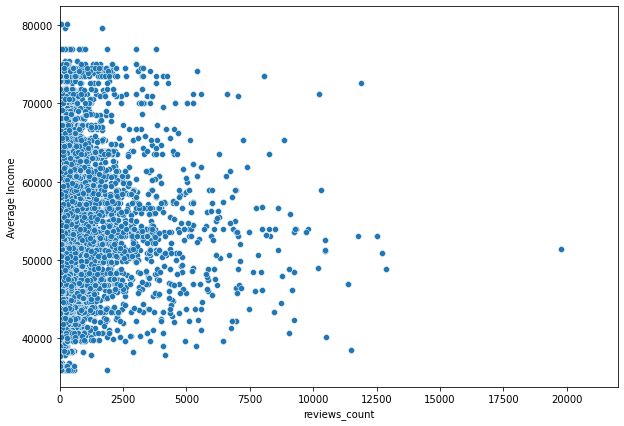

In [82]:
fig_dims = (10, 7)
fig = plt.subplots(figsize=fig_dims)
fig=sns.scatterplot(data=data,x='reviews_count',y='Average Income')
fig.set(xlim=(0,22000))

## Is there a specific neighboorhood that people order more?

Most Ordered (reviewed) restaurants are in zones 1,3 and 4. Suming up to 66% of all the reviews.

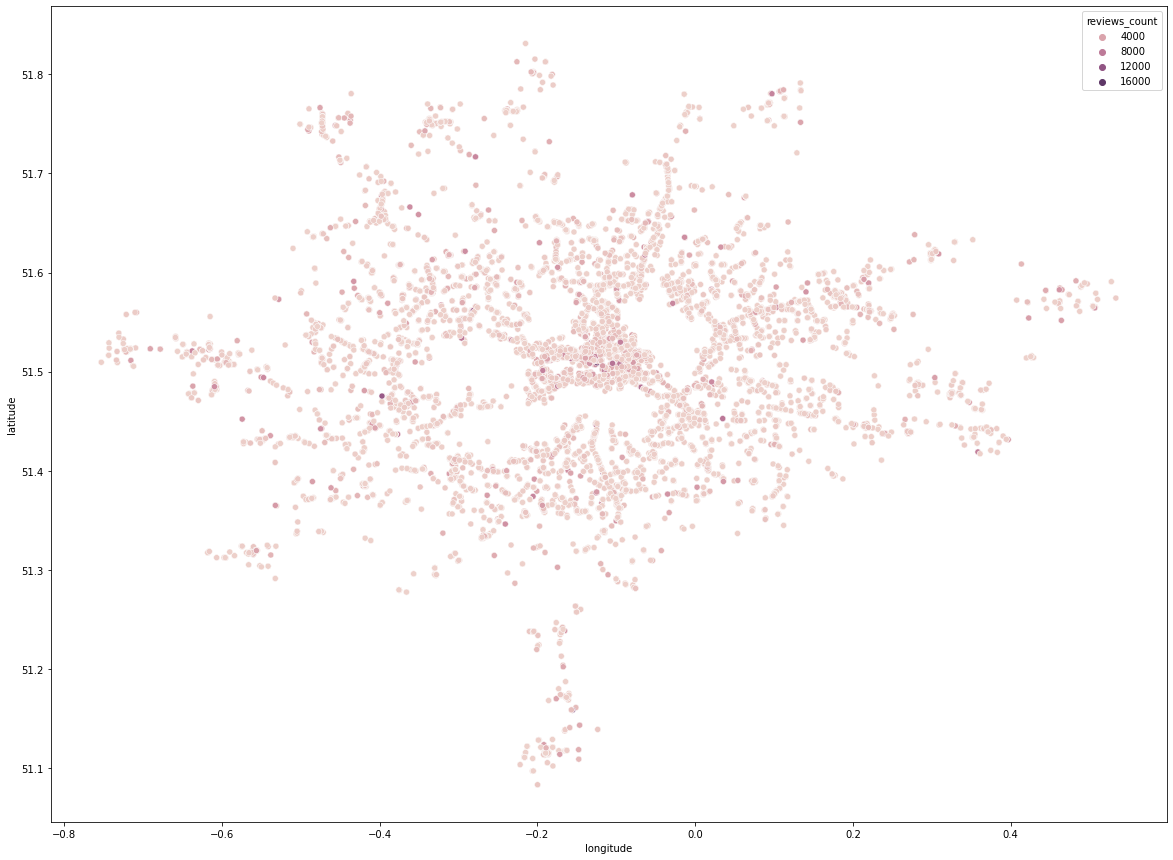

In [83]:
fig_dims = (20, 15)
fig = plt.subplots(figsize=fig_dims)
fig=sns.scatterplot(data=data[data['reviews_count']<22000],x='longitude',y='latitude',hue='reviews_count')
#fig.set(xlim=(0,22000))

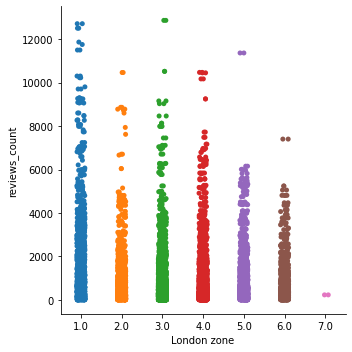

In [84]:
sns.catplot(x='London zone', y='reviews_count',data=data[data['reviews_count']<15000])

In [85]:
orders_per_zone=pd.DataFrame(data.groupby(['London zone'])['reviews_count'].sum())
(orders_per_zone,zonemost_ordered_list)=return_paretto(orders_per_zone,'London zone','reviews_count',80)

In [86]:
orders_per_zone

,London zone,count,percentage
0,4.0,2436516.0,22.433819
1,1.0,2407872.0,22.170084
2,3.0,2273232.0,20.930409
3,5.0,1579320.0,14.541328
4,2.0,1197462.0,11.025434
5,6.0,966042.0,8.894672
6,7.0,462.0,0.004254


## Any correlation between Income and Zone?

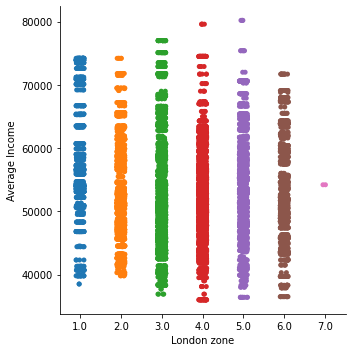

In [87]:
sns.catplot(x='London zone', y='Average Income',data=data)

## Which London Zone are chains located?

In [89]:
df

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine2,AddressLine3,AddressLine4,postcode,...,Scores.ConfidenceInManagement.@xsi:nil,Geocode.Longitude.@xsi:nil,Geocode.Latitude.@xsi:nil,latlon,London zone_x,ITL level 2_x,Average Income_x,London zone_y,ITL level 2_y,Average Income_y
0,468824,1317,"""Rio Cinema""",Restaurant/Cafe/Canteen,1,Rio Cinema Dalston,103-107 Kingsland High Street,London,None,E8 2PB,...,NaN,NaN,NaN,51.5495-0.0756,2.0,Inner London - East,56000.0,2.0,Inner London - East,56000.0
1,1177669,19/00376/COMM,% Arabica,Takeaway/sandwich shop,7844,Basement And Ground Floor,5 King Street,Covent Garden,London,WC2E 8HN,...,NaN,NaN,NaN,51.5117-0.124,1.0,Inner London - West,59000.0,1.0,Inner London - West,59000.0
2,1220366,191074,% Arabica,Manufacturers/packers,7839,Railway Arch 214,Ponsford Street,Hackney,London,E9 6JU,...,NaN,NaN,NaN,51.5473-0.0485,2.0,Inner London - East,52200.0,2.0,Inner London - East,52200.0
3,1225476,130435,%Arabica,Other catering premises,7841,Basement To Ground Floor,33 Broadway Market,Hackney,London,E8 4PH,...,NaN,NaN,NaN,51.5365-0.0621,2.0,Inner London - East,56900.0,2.0,Inner London - East,56900.0
4,463541,PI/000187321,( Pitches 46 & 47 & 48)Jean Hogg,Retailers - other,4613,Lewisham Market,Lewisham High Street,Hither Green,London,SE13 6JG,...,NaN,NaN,NaN,51.462-0.0108,2.0,Inner London - East,50700.0,2.0,Inner London - East,50700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43825,428126,01521/0005/0/000,Zuma,Restaurant/Cafe/Canteen,1,5 Raphael Street,London,None,None,SW7 1DL,...,NaN,NaN,NaN,51.5009-0.1629,1.0,Inner London - West,56300.0,1.0,Inner London - West,56300.0
43826,1246213,20/00197/COMM,Zumak39,Restaurant/Cafe/Canteen,1,39 Panton Street,London,None,None,SW1Y 4EA,...,NaN,NaN,NaN,51.5096-0.1319,1.0,Inner London - West,59000.0,1.0,Inner London - West,59000.0
43827,894118,13/00338/COMM,Zumbura,Restaurant/Cafe/Canteen,1,Business,36A Old Town,London,None,SW4 0LB,...,NaN,NaN,NaN,51.4642-0.1418,2.0,Inner London - East,66000.0,2.0,Inner London - East,66000.0
43828,640333,10/00058/FOOD,Zus Sizzlers,Takeaway/sandwich shop,7844,83 Green Street,Forest Gate,London,None,E7 8JF,...,NaN,NaN,NaN,51.54460.0322,3.0,Inner London - East,49500.0,3.0,Inner London - East,49500.0


<AxesSubplot:xlabel='London zone_x', ylabel='count'>

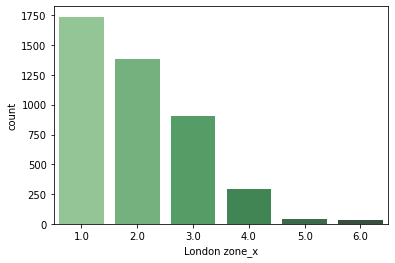

In [90]:
chains_df=df[df['BusinessName'].isin(chains_list)]
sns.countplot(x="London zone_x", data=chains_df, palette="Greens_d")

In [91]:
chains_df=pd.DataFrame(df[df['BusinessType'].isin(chains_list)]['BusinessName'].value_counts())

## Is there any correlation among review score from UK Food Agency and Uber eats review score?

<AxesSubplot:xlabel='average_rating', ylabel='RatingValue'>

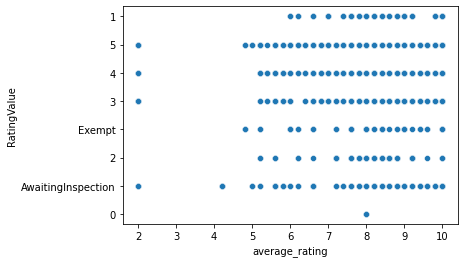

In [92]:
sns.scatterplot(data=incommon_df,x='average_rating',y='RatingValue')

<AxesSubplot:xlabel='average_rating', ylabel='Scores.Hygiene'>

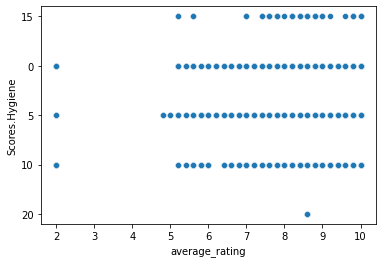

In [93]:
sns.scatterplot(data=incommon_df,x='average_rating',y='Scores.Hygiene')

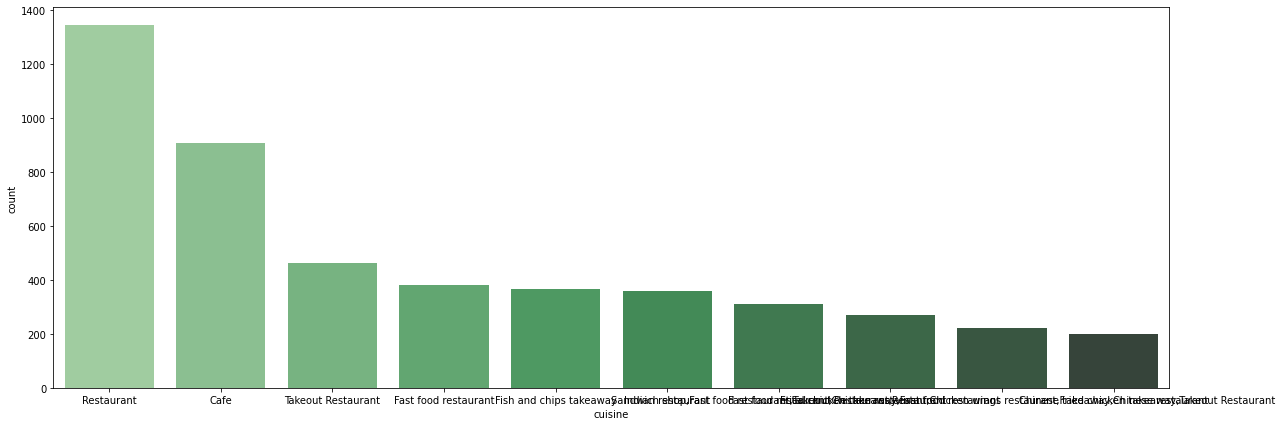

In [94]:
fig_dims = (20, 7)
fig = plt.subplots(figsize=fig_dims)
fig=sns.countplot(x="cuisine", data=data, palette="Greens_d",
              order=data.cuisine.value_counts().iloc[0:10].index)